# Accelerated EFTofLSS predictions with `EFTEMU`

In this notebook we introduce the `EFTEMU` that is part of the suite of emulators included with `matryoshka`. The purpose of this emulator is to accelerate EFTofLSS analyses. The emulator has been trained to predict the monopole $P_0$ and quandrupole $P_2$ returned by [PyBird](https://github.com/pierrexyz/pybird).

We start by importing all the modules required for this example.

In [1]:
import matryoshka.eft_funcs as MatEFT
import matryoshka.halo_model_funcs as MatHM
import matryoshka.emulator as MatEmu
import matryoshka.plot as MatPlt
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.optimize import minimize
from scipy.stats import norm
import zeus
import corner

Next we load the cosmologies that for the train and test sets for `EFTEMU`. These training samples were chosen to overlap the [Aemulus](https://aemulusproject.github.io) and [AbacusSummit](https://abacussummit.readthedocs.io/en/latest/) simulation samples, and were generated using the `matryoshka.training_funcs.Resampler` class.

It should be noted that these cosmological parameters are the **only** input for the NNs that the `EFTEMU` is based on.
In equation 10 of [d'Amico et al. (2019)](https://iopscience.iop.org/article/10.1088/1475-7516/2020/05/005) they write the power spectrum as a sum of terms that are bias independant. Training the emulator to predict these bias independant terms rather than $P_0$ or $P_2$ directly is advantageous because it greatly reduces the dimensionality of the input.

In [2]:
cosmos = np.load("/Users/jamie/Desktop/EFT/notebooks/eft_cosmologies_noDQ1.npy")

We plot these samples to visualise the extent of the space covered.

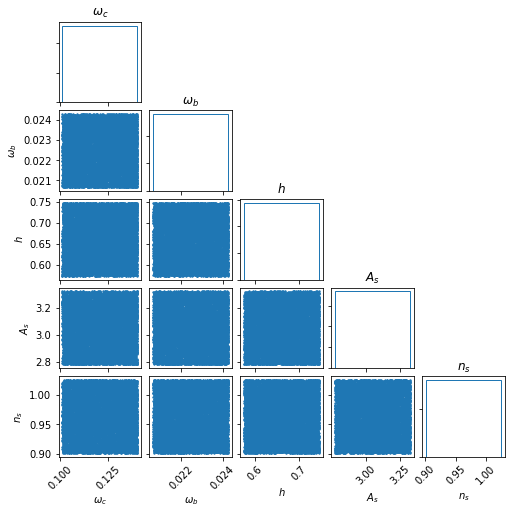

In [3]:
param_labels = param_labels = [r"$\omega_c$",r"$\omega_b$",r"$h$",r"$A_s$",r"$n_s$"]
MatPlt.sample_space([cosmos], param_labels, figsize=(8,8))

Next we initalise `EFTEMU` for $P_0$ and $P_2$.

In [4]:
P0_emu = MatEmu.EFT(0, version='EFT-optiresum')
P2_emu = MatEmu.EFT(2, version='EFT-optiresum')

2021-11-26 16:20:49.101428: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


We also load the training and test sets for `EFTEMU` so we can assess the prediction accuracy.

In [5]:
path_to_eft_data = "/Users/jamie/Desktop/EFT/data/"

P110_array = np.load(path_to_eft_data+"P110_array-z0.51_noDQ1_optiresum-True.npy")
Ploop0_array = np.load(path_to_eft_data+"Ploop0_array-z0.51_noDQ1_optiresum-True.npy")
Pct0_array = np.load(path_to_eft_data+"Pct0_array-z0.51_noDQ1_optiresum-True.npy")
P112_array = np.load(path_to_eft_data+"P112_array-z0.51_noDQ1_optiresum-True.npy")
Ploop2_array = np.load(path_to_eft_data+"Ploop2_array-z0.51_noDQ1_optiresum-True.npy")
Pct2_array = np.load(path_to_eft_data+"Pct2_array-z0.51_noDQ1_optiresum-True.npy")

test_id = np.load("/Users/jamie/Desktop/EFT/split/test.npy")
train_id = np.load("/Users/jamie/Desktop/EFT/split/train.npy")

We are not so interested in the prediction accuracy of these bias independant terms but rather the multipoles $P_0$ and $P_2$. This means that we need to generate multipoles from the bias free componenets, and this means we need to decide what bias parameters we should use.

For this notebook we simply take random draws from the priors that were used in [d'Amico et al. (2019)](https://iopscience.iop.org/article/10.1088/1475-7516/2020/05/005) (equation 35). This will lead to some strange sets of bias parameters and may not be the best method to assess the predicion accuracy on $P_0$ and $P_2$, however it is the simplest.

Define a simple function that will generate samples from the prior.

In [6]:
def random_bias(N):
    b1 = np.random.uniform(0,4, size=N)
    
    c2 = np.random.uniform(-4,4, size=N)
    c4 = np.random.normal(loc=0,scale=2, size=N)
    
    b2 = 1/np.sqrt(2)*(c2+c4)
    b4 = 1/np.sqrt(2)*(c2-c4)
    
    b3 = np.random.normal(loc=0,scale=2, size=N)
    
    cct = np.random.normal(loc=0,scale=2, size=N)
    
    cr1 = np.random.normal(loc=0,scale=4, size=N)
    cr2 = np.random.normal(loc=0,scale=2, size=N)
    
    return np.vstack([b1, b2, b3, b4, cct, cr1, cr2]).T

We generate random sets of bias parameters for each sample in the training and test sets.

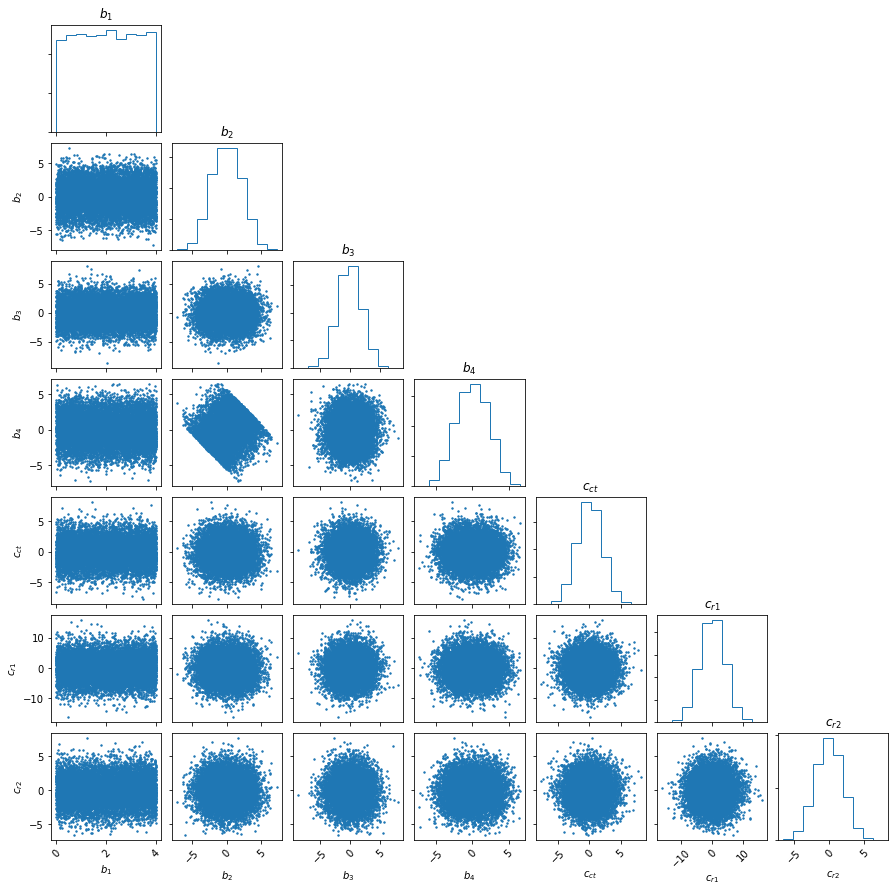

In [7]:
random_bs = random_bias(cosmos.shape[0])

bias_labels = [r"$b_1$", r"$b_2$", r"$b_3$", r"$b_4$", r"$c_{ct}$", r"$c_{r1}$", r"$c_{r2}$"]
MatPlt.sample_space([random_bs], bias_labels)

We can now calculate the multipoles.

In [8]:
P0_train_test = np.zeros((cosmos.shape[0], MatEmu.kbird[:39].shape[0]))
P2_train_test = np.zeros((cosmos.shape[0], MatEmu.kbird[:39].shape[0]))
f_train_test = MatHM.fN_vec(cosmos[:,0]/cosmos[:,2]**2, 0.51)
for i in range(cosmos.shape[0]):
    f = MatHM.fN(cosmos[i,0]/cosmos[i,2]**2, 0.51)
    P0_train_test[i,:] = MatEFT.multipole([P110_array[i],
                                     Ploop0_array[i],
                                     Pct0_array[i]],
                                     random_bs[i],
                                     f)[:39] # We impose a scale cut here as in the current version of matryoshka
                                             # EFTEMU does not make predictions up to k=0.3h/Mpc
    P2_train_test[i,:] = MatEFT.multipole([P112_array[i], 
                                     Ploop2_array[i],
                                     Pct2_array[i]],
                                     random_bs[i],
                                     f)[:39]

Now we can check the prediction accuracy.

In [9]:
start = time.time()
P0_preds = P0_emu.emu_predict(cosmos, random_bs)
P2_preds = P2_emu.emu_predict(cosmos, random_bs)
end = time.time()

print("{a} predictions made in {b} seconds.".format(a=cosmos.shape[0],
                                                    b=np.round(end-start,3)))

10000 predictions made in 0.872 seconds.


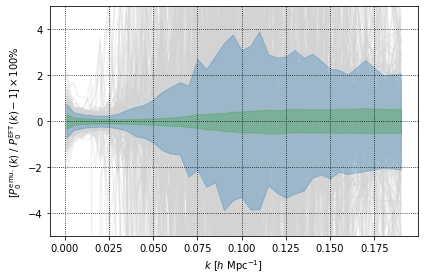

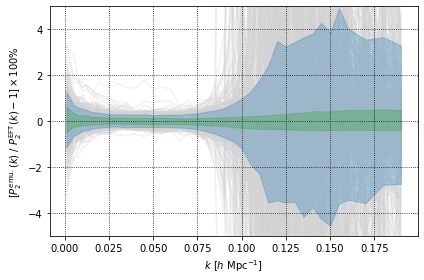

In [10]:
MatPlt.per_err(P0_train_test[test_id], P0_preds[test_id], MatEmu.kbird[:39], ylim=(-5,5),
               xlabel=r"$k \ [h \ \mathrm{Mpc}^{-1}]$", 
               ylabel=r"$[P_0^\mathrm{emu.}(k) \ / \ P_0^\mathrm{EFT}(k)-1] \times 100\%$")

MatPlt.per_err(P2_train_test[test_id], P2_preds[test_id], MatEmu.kbird[:39], ylim=(-5,5),
               xlabel=r"$k \ [h \ \mathrm{Mpc}^{-1}]$", 
               ylabel=r"$[P_2^\mathrm{emu.}(k) \ / \ P_2^\mathrm{EFT}(k)-1] \times 100\%$")

The plots above do not really indicate the prediction accuracy for sensible sets of bias parameters but rather visualise a worst case scenario.

We can produce a very rough estimate of the average prediction error across the test set.

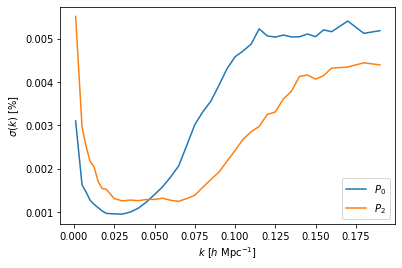

In [11]:
P0_pred_std = np.quantile((P0_train_test[test_id]/P0_preds[test_id]-1),[0.16,1-0.16],axis=0)
P0_pred_std = np.diff(P0_pred_std, axis=0)[0]/2
P2_pred_std = np.quantile((P2_train_test[test_id]/P2_preds[test_id]-1),[0.16,1-0.16],axis=0)
P2_pred_std = np.diff(P2_pred_std, axis=0)[0]/2

plt.figure(1)

plt.plot(MatEmu.kbird[:39], P0_pred_std, label=r'$P_0$')
plt.plot(MatEmu.kbird[:39], P2_pred_std, label=r'$P_2$')

plt.xlabel(r"$k \ [h \ \mathrm{Mpc}^{-1}]$")
plt.ylabel(r"$\sigma(k) \ [\%]$")

plt.legend()

plt.show()

To investigate how this level of prediction accuracy propgates into constraints on cosmological and bias parameters we run perform an MCMC using a $P_0$ and $P_2$ calculated using `PyBird` with the Planck 2018 $\Lambda$CDM cosmology and reasonable bias parameters.

In [12]:
fid_bs = np.array([2., 1., 0.5, 0., 0.5, 2., 0.]) # These are the parameters from the PyBird example notebook.
fid_cosmo = np.array([0.11933, 0.02242, 0.6766, 3.047, 0.9665])

P110_P18 = np.load(path_to_eft_data+"P110-z0.51_P18_optiresum-True.npy")
Ploop0_P18 = np.load(path_to_eft_data+"Ploop0-z0.51_P18_optiresum-True.npy")
Pct0_P18 = np.load(path_to_eft_data+"Pct0-z0.51_P18_optiresum-True.npy")
P112_P18 = np.load(path_to_eft_data+"P112-z0.51_P18_optiresum-True.npy")
Ploop2_P18 = np.load(path_to_eft_data+"Ploop2-z0.51_P18_optiresum-True.npy")
Pct2_P18 = np.load(path_to_eft_data+"Pct2-z0.51_P18_optiresum-True.npy")

f = MatHM.fN(fid_cosmo[0]/fid_cosmo[2]**2, 0.51)
P0_fid = MatEFT.multipole([P110_P18,
                                 Ploop0_P18,Pct0_P18],fid_bs,f)[:39]
P2_fid = MatEFT.multipole([P112_P18, 
                                 Ploop2_P18,Pct2_P18],fid_bs,f)[:39]

Before running our MCMC we can make predictions with the emulators and the true parameters.

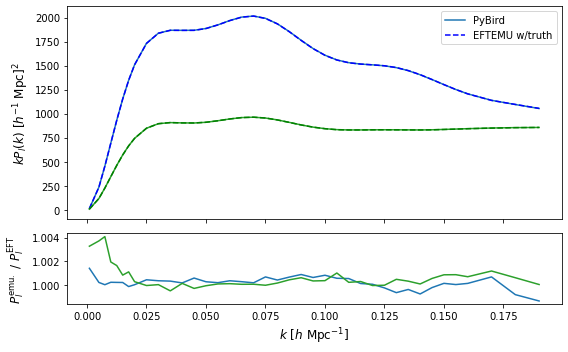

In [13]:
P0_fid_pred = P0_emu.emu_predict(fid_cosmo.reshape(1,-1), fid_bs.reshape(1,-1))[0]
P2_fid_pred = P2_emu.emu_predict(fid_cosmo.reshape(1,-1), fid_bs.reshape(1,-1))[0]

fig, ax = plt.subplots(2,1, sharex=True, figsize=(8,5), gridspec_kw={'height_ratios': [3, 1]})

ax[0].plot(MatEmu.kbird[:39], MatEmu.kbird[:39]*P0_fid, color="tab:blue", label="PyBird")
ax[0].plot(MatEmu.kbird[:39], MatEmu.kbird[:39]*P0_fid_pred, color="blue", linestyle='--', label="EFTEMU w/truth")

ax[0].plot(MatEmu.kbird[:39], MatEmu.kbird[:39]*P2_fid, color="tab:green")
ax[0].plot(MatEmu.kbird[:39], MatEmu.kbird[:39]*P2_fid_pred, color="green", linestyle='--')

ax[1].plot(MatEmu.kbird[:39], P0_fid/P0_fid_pred, color="tab:blue")
ax[1].plot(MatEmu.kbird[:39], P2_fid/P2_fid_pred, color="tab:green")

ax[1].set_xlabel(r'$k \ [h \ \mathrm{Mpc}^{-1}]$',fontsize='large')
ax[0].set_ylabel(r'$kP_l(k) \ [h^{-1} \ \mathrm{Mpc}]^2$',fontsize='large')
ax[1].set_ylabel(r'$P_l^\mathrm{emu.} \ / \ P_l^\mathrm{EFT}$',fontsize='large')

ax[0].legend()

plt.tight_layout()

plt.show()

We will be running our MCMC with [zeus](https://zeus-mcmc.readthedocs.io/en/latest/index.html). Bellow we define the functions that form the log probabolity that we will pass to `zeus`.

Note that we will be using $c_2$ and $c_4$ rather than $b_2$ and $b_4$, this is following [d'Amico et al. (2019)](https://iopscience.iop.org/article/10.1088/1475-7516/2020/05/005) (see section 3.5).

In [14]:
def log_prior(x):
    # Oc, Ob, h, As, ns
    cosmo = x[:,:5]
    # b1, c2, b3, c4, cct, cr1, cr2
    bias = x[:,5:]
    
    # Flat prior on the cosmological parameters.
    box_cosmo = np.greater(cosmo[:, 0], 0.10121926) & np.less(cosmo[:, 0], 0.13999676) \
        & np.greater(cosmo[:, 1], 0.02066472) & np.less(cosmo[:, 1], 0.02427991) \
        & np.greater(cosmo[:, 2], 0.57451438) & np.less(cosmo[:, 2], 0.74766042)\
        & np.greater(cosmo[:, 3], 2.77885117) & np.less(cosmo[:, 3], 3.32142323)\
        & np.greater(cosmo[:, 4], 0.90120542) & np.less(cosmo[:, 4], 1.02488991)
    
    # Flat prior on a selection of the bias parameters
    box_bias = np.greater(bias[:, 0], 0.) & np.less(bias[:, 0], 4.) \
        & np.greater(bias[:, 1], -4.) & np.less(bias[:, 1], 4.)
    
    return np.where(box_cosmo, 0, -np.inf)+np.where(box_bias, 0, -np.inf)\
           +norm.logpdf(bias[:,2], loc=0, scale=2)\
           +norm.logpdf(bias[:,3], loc=0, scale=2)\
           +norm.logpdf(bias[:,4], loc=0, scale=2)\
           +norm.logpdf(bias[:,5], loc=0, scale=4)\
           +norm.logpdf(bias[:,6], loc=0, scale=2)

def log_like(x, obs, err):
    # Oc, Ob, h, As, ns
    cosmo = x[:,:5]
    # b1, c2, b3, c4, cct, cr1, cr2
    bias = x[:,5:]
    
    c2 = np.copy(bias[:,1])
    c4 = np.copy(bias[:,3])
    
    # b1, b2, b3, b4, cct, cr1, cr2
    bias[:,1] = (c2+c4)/np.sqrt(2)
    bias[:,3] = (c2-c4)/np.sqrt(2)
    
    P0_pred = P0_emu.emu_predict(cosmo, bias)
    P2_pred = P2_emu.emu_predict(cosmo, bias)
    
    pred = np.hstack([P0_pred, P2_pred])
    
    return -0.5*np.sum(((pred-obs)/(err*pred))**2, axis=1)

def log_prob(theta, obs, err):
    theta = np.vstack(theta)
    lp = log_prior(theta)
    ll = log_like(theta, obs, err)
    return ll+lp

def neg_log_prob(theta, obs, err):
    theta = np.array(theta).reshape(1, -1)
    return -(log_prob(theta, obs, err))

Before running our MCMC we quickly calculate the best fit parameters. With an inital guesses that are perturbations of the truth.

In [15]:
init_cosmo = np.copy(fid_cosmo)+1e-3*np.random.randn(5)
init_bias = np.copy(fid_bs)+1e-2*np.random.randn(7)
init_bias[1] = np.sqrt(2)/2*(fid_bs[1]+fid_bs[3])
init_bias[3] = np.sqrt(2)/2*(fid_bs[1]-fid_bs[3])

obs_pow = np.hstack([P0_fid, P2_fid])
err = np.hstack([P0_pred_std, P2_pred_std])

results = minimize(neg_log_prob, np.hstack([init_cosmo,init_bias]), args=(obs_pow, err),
                   options={'disp': True, "maxiter": 100000}, method='Nelder-Mead')

Optimization terminated successfully.
         Current function value: 12.156676
         Iterations: 750
         Function evaluations: 1081


We can make predictions for the best fit parameters and plot these versus the truth.

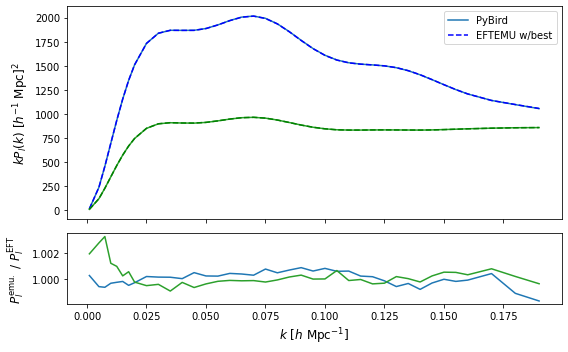

In [16]:
best_bias = results.x[5:]
c2_best = best_bias[1]
c4_best = best_bias[3]
best_bias[1] = (c2_best+c4_best)/np.sqrt(2)
best_bias[3] = (c2_best-c4_best)/np.sqrt(2)
best_cosmo = results.x[:5]

P0_best = P0_emu.emu_predict(best_cosmo.reshape(1,-1), best_bias.reshape(1,-1))[0]
P2_best = P2_emu.emu_predict(best_cosmo.reshape(1,-1), best_bias.reshape(1,-1))[0]

fig, ax = plt.subplots(2,1, sharex=True, figsize=(8,5), gridspec_kw={'height_ratios': [3, 1]})

ax[0].plot(MatEmu.kbird[:39], MatEmu.kbird[:39]*P0_fid, color="tab:blue", label="PyBird")
ax[0].plot(MatEmu.kbird[:39], MatEmu.kbird[:39]*P0_best, color="blue", linestyle='--', label="EFTEMU w/best")

ax[0].plot(MatEmu.kbird[:39], MatEmu.kbird[:39]*P2_fid, color="tab:green")
ax[0].plot(MatEmu.kbird[:39], MatEmu.kbird[:39]*P2_best, color="green", linestyle='--')

ax[1].plot(MatEmu.kbird[:39], P0_fid/P0_best, color="tab:blue")
ax[1].plot(MatEmu.kbird[:39], P2_fid/P2_best, color="tab:green")

ax[1].set_xlabel(r'$k \ [h \ \mathrm{Mpc}^{-1}]$',fontsize='large')
ax[0].set_ylabel(r'$kP_l(k) \ [h^{-1} \ \mathrm{Mpc}]^2$',fontsize='large')
ax[1].set_ylabel(r'$P_l^\mathrm{emu.} \ / \ P_l^\mathrm{EFT}$',fontsize='large')

ax[0].legend()

plt.tight_layout()

plt.show()

In the cell bellow we define the setup of our MCMC, as well as the inital positions of the walkers.

In [17]:
nwalk = results.x.shape[0]*2
ndim = results.x.shape[0]
init_pos = results.x+1e-4*np.random.randn(nwalk, ndim)

We will be moinitoring convergence of our chains by monitoring the autocorrelation time, once we have run for more than $50\tau$ and our estimate of $\tau$ has converged to within $1\%$ we will stop the chain. `zeus` has in-built functions that allow us to do this very easily.

In [18]:
cb0 = zeus.callbacks.AutocorrelationCallback(ncheck=100, dact=0.01, nact=50, discard=0.5)
cb1 = zeus.callbacks.MinIterCallback(nmin=1000)

Now we finally run our MCMC!

In [19]:
sampler = zeus.EnsembleSampler(nwalk, ndim, log_prob, args=(obs_pow,err), vectorize=True)
start = time.time()
sampler.run_mcmc(init_pos, 10000, progress=True, callbacks=[cb0, cb1])
end = time.time()
print("{a} likelihood evaluations in {b} minutes.".format(a=sampler.ncall, b=np.round((end-start)/60,1)))

Initialising ensemble of 24 walkers...
Sampling progress :  27%|██████████████▎                                      | 2700/10000 [04:19<11:41, 10.41it/s]

335447 likelihood evaluations in 4.3 minutes.


We discard the first $5\tilde{\tau}$ steps in the chain and produce trace plots for each of the variables.

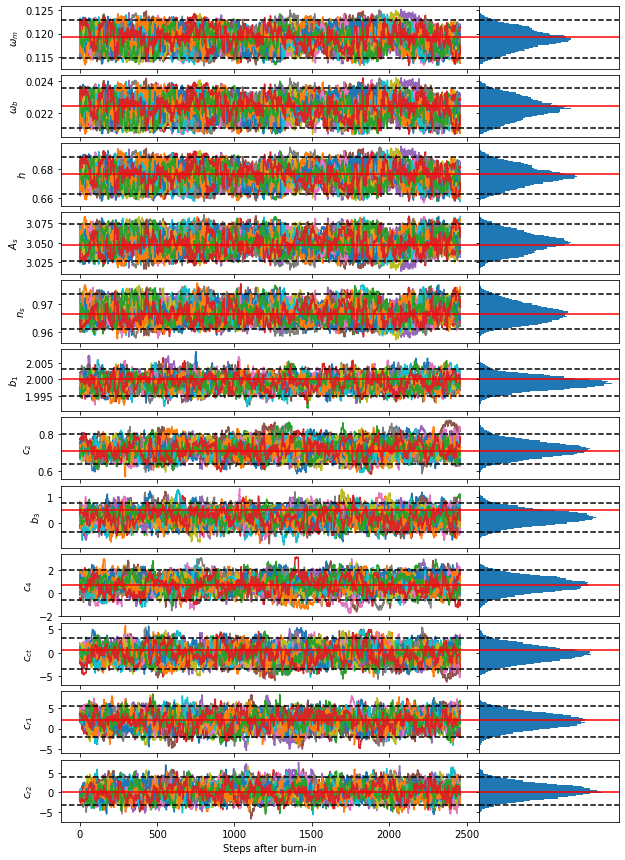

In [20]:
discard = zeus.AutoCorrTime(sampler.get_chain()).mean()*5
chain = sampler.get_chain(flat=False, discard=int(discard))
flat_chain = sampler.get_chain(flat=True, discard=int(discard))

param_labels = [r"$\omega_c$",r"$\omega_b$",r"$h$",r"$A_s$",r"$n_s$", r"$b_1$", r"$c_2$",
                r"$b_3$", r"$c_4$", r"$c_{ct}$", r"$c_{r1}$", r"$c_{r2}$"]
truths = np.hstack([fid_cosmo, np.array(fid_bs)])
truths[5+1] = np.sqrt(2)/2*(fid_bs[1]+fid_bs[3])
truths[5+3] = np.sqrt(2)/2*(fid_bs[1]-fid_bs[3])

fig, ax = plt.subplots(12,2, figsize=(10,15), gridspec_kw={'width_ratios':[3,1]}, sharex='col', sharey='row')

for i in range(12):
    ax[i,0].plot(chain[:,:,i])
    ax[i,0].set_ylabel(param_labels[i])
    ax[i,1].hist(chain[:,:,i].flatten(),bins=50, orientation='horizontal')
    #ax[i,1].set_frame_on(False)
    ax[i,1].set_xticks([])
    for j in range(2):
        ax[i,j].axhline(truths[i], color='red')
        for q in [0.025, 0.975]:
            ax[i,j].axhline(np.quantile(chain[:,:,i].flatten(), q), color='k', linestyle='--')

ax[-1,0].set_xlabel("Steps after burn-in")
plt.subplots_adjust(hspace=0.1, wspace=0.)
plt.show()

We then produce a corner plot using the [corner](https://corner.readthedocs.io/en/latest/) package. Before plotting we apply some rescaling such that the means of each of the marginalised 1D posteriors is $\mathcal{O}(1)$.

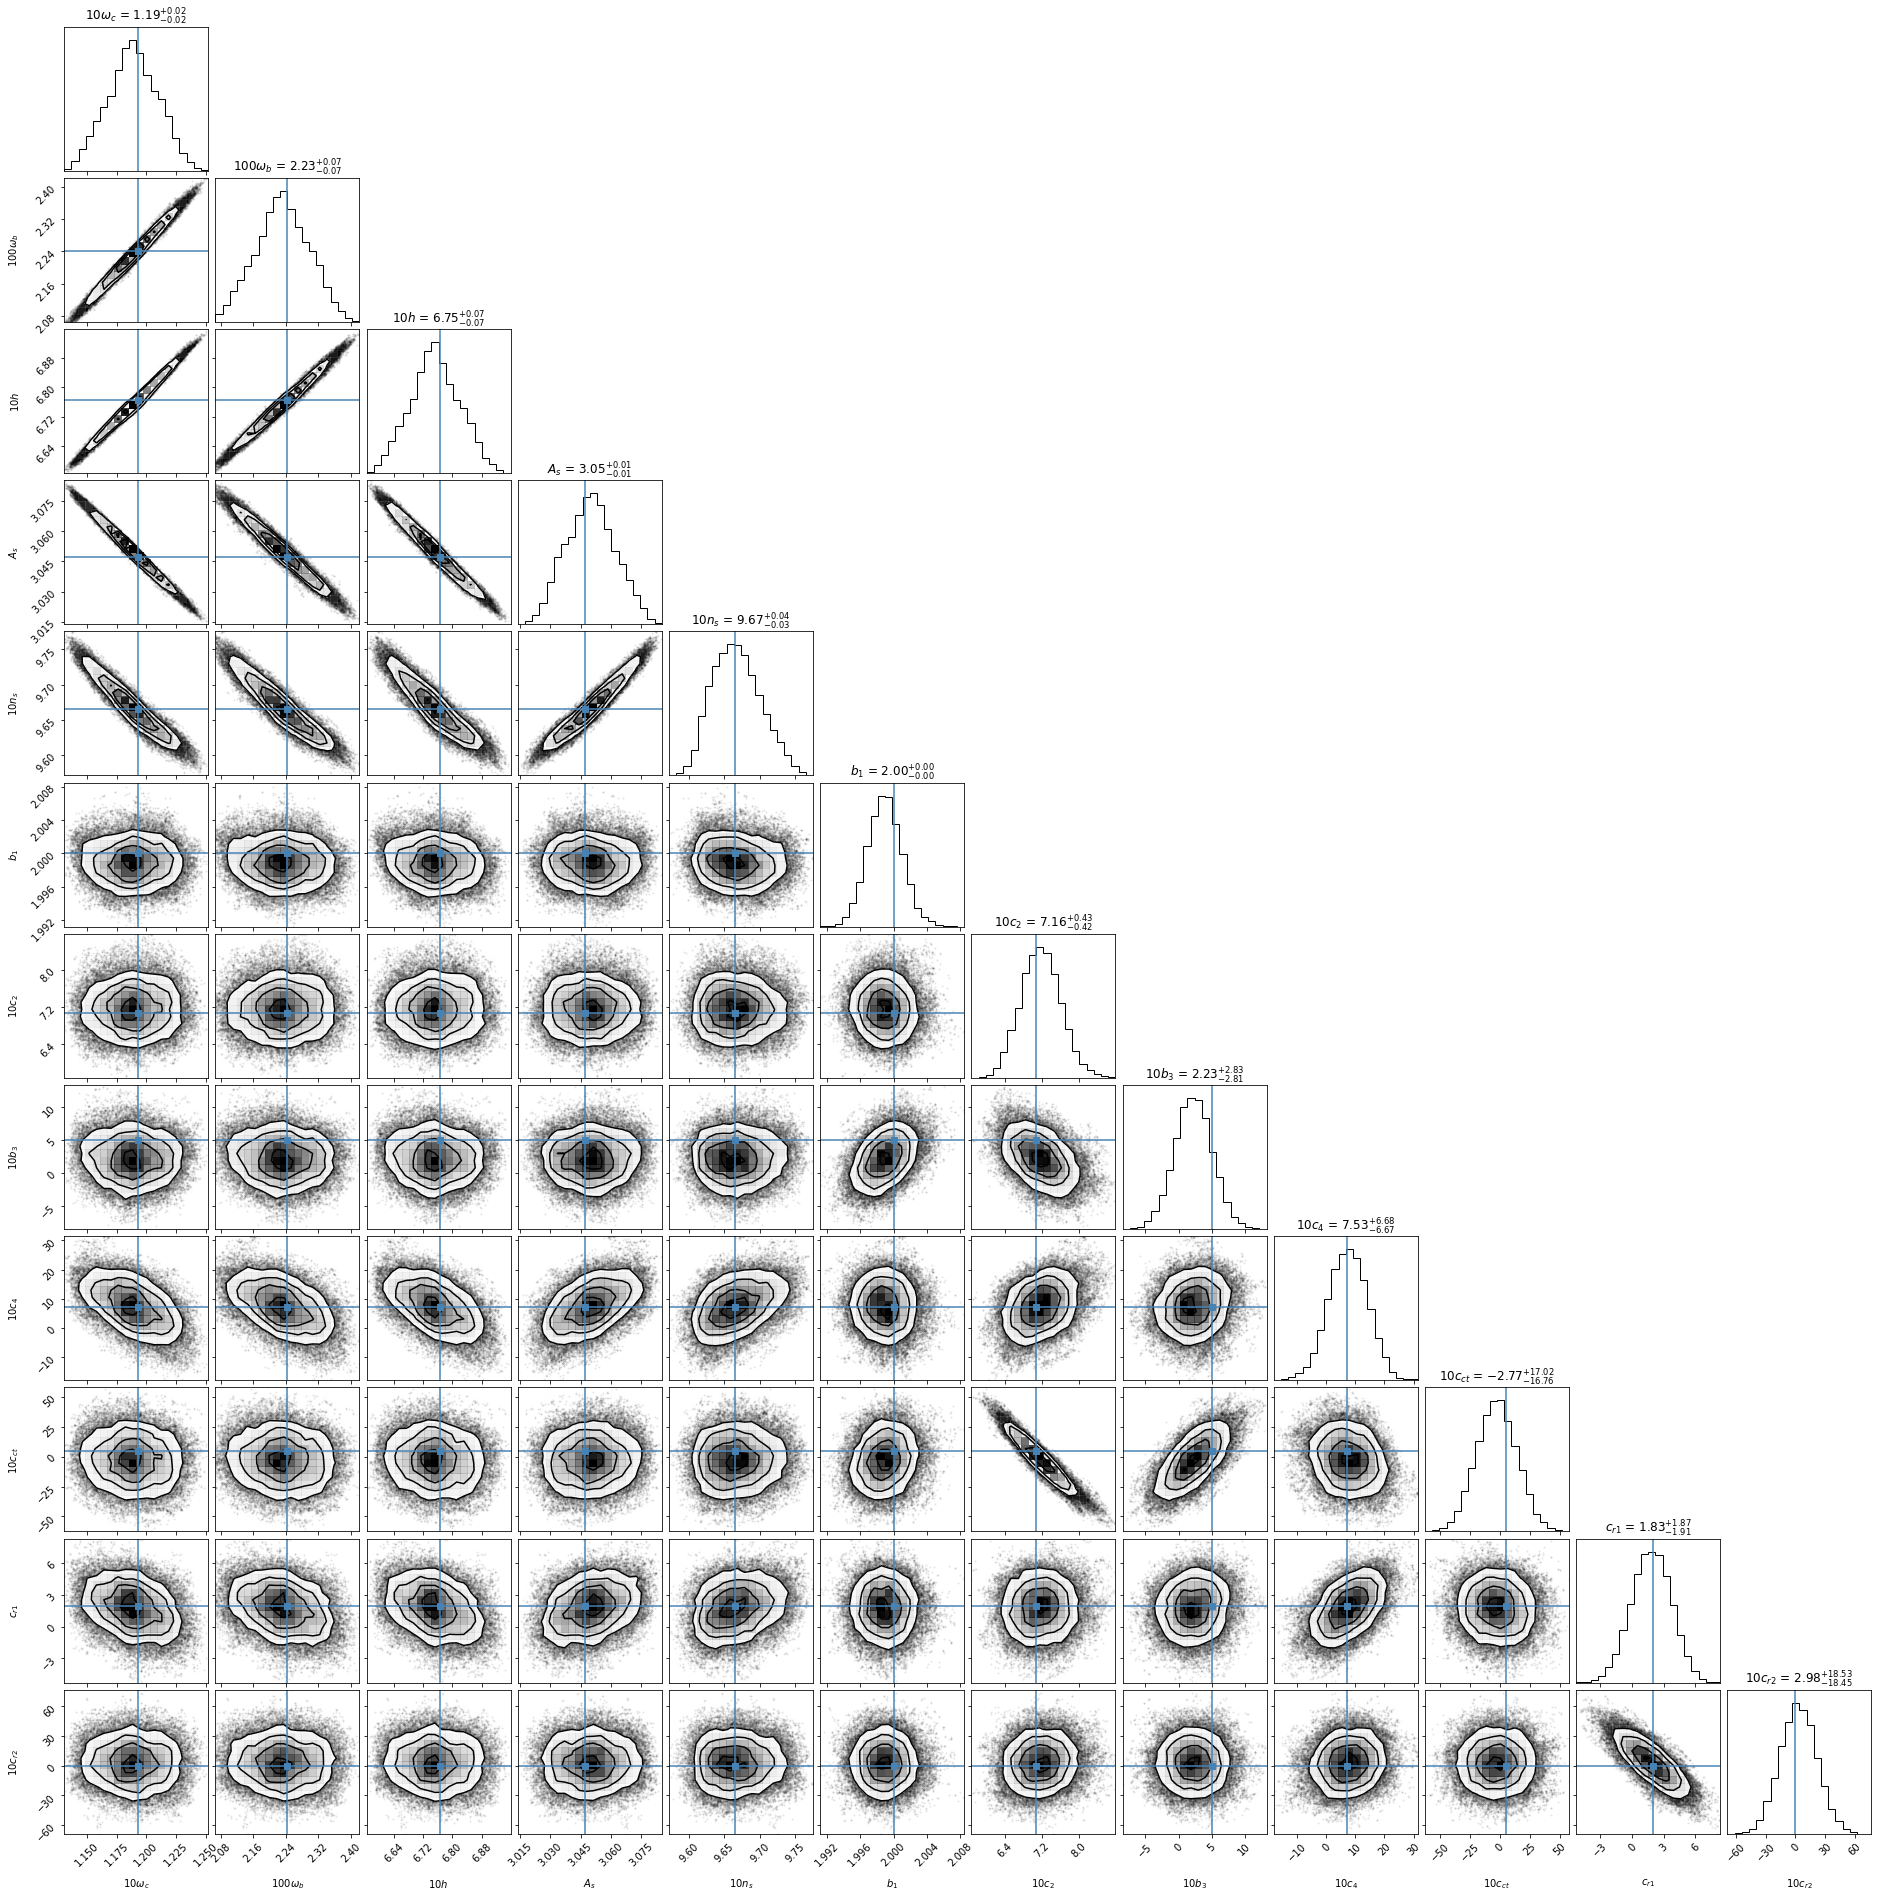

In [21]:
param_labels = [r"$10\omega_c$",r"$100\omega_b$",r"$10h$",r"$A_s$",r"$10n_s$", r"$b_1$", r"$10c_2$",
                r"$10b_3$", r"$10c_4$", r"$10c_{ct}$", r"$c_{r1}$", r"$10c_{r2}$"]
flat_chain[:,[0,1,2,4,6,7,8,9,11]] = flat_chain[:,[0,1,2,4,6,7,8,9,11]]*10
truths[[0,1,2,4,6,7,8,9,11]] = truths[[0,1,2,4,6,7,8,9,11]]*10
flat_chain[:,1] = flat_chain[:,1]*10
truths[1] = truths[1]*10
corner.corner(flat_chain, labels=param_labels, truths=truths, show_titles=True);

We can see that there is no significant bias introduced in the constraints on the cosmlogical parameters.